In [2]:
%reload_ext autoreload
%autoreload 2
import copy

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pygmo

import logging
logging.basicConfig(level=logging.DEBUG)

In [3]:
# Local
import robustranking as rr
# from robustranking.benchmark import Benchmark
# from robustranking.comparison import BootstrapComparison, AggregatedComparison, MOBootstrapComparison
# from robustranking.utils.plots import *
# from robustranking.utils.multiobjective import fast_non_dominated_sorting, dominates

## Read and process data
SAT competition 2016 - Main track

In [4]:
df = pd.read_csv("./Rundata/sc2016-detailed-results/main.csv")

df["solver"] = df["solver"] + df["configuration"]
df["solved"] = df["status"] == "complete"
df = df[["solver","benchmark", "cpu time", "solved"]]
df = df.rename(columns={"cpu time": "PAR2"})
df
#df[df["objective"] == "solved"].groupby("solver").sum()[0].reset_index().sort_values(0, ascending=False)

,solver,benchmark,PAR2,solved
0,GHackCOMSPS_DRUPghack_drup,sat/10pipe_k.cnf,543.341,True
1,Scavel_SATdefault,sat/10pipe_k.cnf,5000.020,False
2,Beans And Eggsdefault,sat/10pipe_k.cnf,1356.550,True
3,cmsat5_main2default,sat/10pipe_k.cnf,5000.020,False
4,cmsat5_autotune2default,sat/10pipe_k.cnf,1295.360,True
...,...,...,...,...
14495,MapleCOMSPS_LRB_DRUPLRB_VSIDS_drup,sat/sc16craft_tseitingrid7x200_shuffled.cnf,5000.020,False
14496,MapleCOMSPS_DRUPseq_LRB_VSIDS_drup,sat/sc16craft_tseitingrid7x200_shuffled.cnf,5000.020,False
14497,Riss6default_DRAT,sat/sc16craft_tseitingrid7x200_shuffled.cnf,5000.010,False
14498,Riss6blackbox_DRAT,sat/sc16craft_tseitingrid7x200_shuffled.cnf,5000.030,False


## Convert dataframe to Benchmark object
This object can transform to different data structures and perform checks on the benchmark

In [5]:
competition = rr.Benchmark()

competition.from_pandas(df, "solver", "benchmark", ["PAR2", "solved"])
competition.show_stats()

algorithms       29
instances       500
objectives        2
values        29000
complete       True
dtype: object

# SO comparison

In [83]:
s1comparison = rr.comparison.BootstrapComparison(competition.filter(objectives=["solved"]),
                                               minimise=False,
                                               bootstrap_runs=10000,
                                               aggregation_method=np.sum)

s1ranking = s1comparison.get_ranking()

s2comparison = rr.comparison.BootstrapComparison(competition.filter(objectives=["PAR2"]),
                                               minimise=True,
                                               bootstrap_runs=10000,
                                               aggregation_method=np.mean)

s2ranking = s2comparison.get_ranking()

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
DEBUG:root:flip all
INFO:root:Round 0
INFO:root:> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup has with 36.880% the most wins out of all 29 candidates.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from GHackCOMSPS_DRUPghack_drup 2.110% times.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from Scavel_SATdefault 0.000% times.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from Beans And Eggsdefault 12.470% times.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from cmsat5_main2default 0.010% times.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from cmsat5_autotune2default 0.020% times.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from YalSAT 03rdefault 0.000% times.
INFO:root:	> MapleCOMSPS_DRUPseq_LRB_VSIDS_drup loses from Lin

In [87]:
sbranking = s1ranking[["group"]].merge(s2ranking[["group"]], left_index=True, right_index=True, suffixes=("solved", "PAR2"))

## Make MO comparison

In [88]:
comparison = rr.comparison.MOBootstrapComparison(competition,
                                 alpha=0.05,
                                 minimise={"PAR2": True, "solved": False},
                                 bootstrap_runs=10000,
                                 aggregation_method={"PAR2": np.mean, "solved": np.sum})

m1comparison = rr.comparison.MODominationBootstrapComparison(competition,
                                 alpha=0.05,
                                 minimise={"PAR2": True, "solved": False},
                                 bootstrap_runs=10000,
                                 aggregation_method={"PAR2": np.mean, "solved": np.sum})

default_comparison = rr.comparison.AggregatedComparison(competition,
                                          minimise={"PAR2": True, "solved": False},
                                          aggregation_method={"PAR2": np.mean, "solved": np.sum},)

In [97]:
dranking = default_comparison.get_ranking()
sbdranking = sbranking.merge(dranking, left_index=True, right_index=True)
sbdranking

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
/var/folders/b8/41_wfv893tnc356wksp2vkvw0000gn/T/ipykernel_38545/2447309190.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  sbdranking = sbranking.merge(dranking, left_index=True, right_index=True)


,groupsolved,groupPAR2,"(PAR2, rank)","(PAR2, score)","(solved, rank)","(solved, score)"
algorithm,,,,,,
MapleCOMSPS_DRUPseq_LRB_VSIDS_drup,1,1,11,3412.773196,1,204.0
Riss6noPP_DRAT,1,1,5,3377.631526,2,203.0
Lingeling bbc maindefault,1,1,6,3385.744974,3,202.0
glucose_hack_kiel_newScriptmain_new,1,1,7,3404.174933,4,199.0
abcdSAT_drupdefault,1,1,10,3412.462534,6,198.0
tc_glucosedefault,1,1,1,3355.291960,5,198.0
MapleCOMSPS_LRB_DRUPLRB_VSIDS_drup,1,1,4,3368.455730,8,196.0
Riss6default_DRAT,1,1,3,3366.461532,7,196.0
Beans And Eggsdefault,1,1,8,3406.272323,9,195.0


In [74]:
m1ranking = m1comparison.get_ranking()

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
DEBUG:root:flip obj
DEBUG:root:flip obj
INFO:root:Round 0
INFO:root:> Riss6noPP_DRAT has with 22.920% the most wins out of all 29 candidates.
INFO:root:	> Riss6noPP_DRAT loses from GHackCOMSPS_DRUPghack_drup 7.190% times.
INFO:root:	> Riss6noPP_DRAT loses from Scavel_SATdefault 0.000% times.
INFO:root:	> Riss6noPP_DRAT loses from Beans And Eggsdefault 19.940% times.
INFO:root:	> Riss6noPP_DRAT loses from cmsat5_main2default 0.550% times.
INFO:root:	> Riss6noPP_DRAT loses from cmsat5_autotune2default 0.450% times.
INFO:root:	> Riss6noPP_DRAT loses from YalSAT 03rdefault 0.000% times.
INFO:root:	> Riss6noPP_DRAT loses from Lingeling bbc maindefault 46.640% times.
INFO:root:	> Riss6noPP_DRAT loses from glucosedefault 14.220% times.
INFO:root:	> Riss6noPP_DRAT loses

In [101]:
# default_comparison.get_ranking()
ranking = comparison.get_ranking()
ranking

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
DEBUG:root:flip obj
DEBUG:root:flip obj
INFO:root:Round 0
DEBUG:root:candidates_mask=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])
DEBUG:root:GHackCOMSPS_DRUPghack_drup     9
DEBUG:root:Scavel_SATdefault              0
DEBUG:root:Beans And Eggsdefault          453
DEBUG:root:cmsat5_main2default            1
DEBUG:root:cmsat5_autotune2default        0
DEBUG:root:YalSAT 03rdefault              0
DEBUG:root:Lingeling bbc maindefault      2909
DEBUG:root:glucosedefault                 136
DEBUG:root:CHBR_glucosedefault            0
DEBUG:root:CHBR_glucose_tuneddefault      0
DEBUG:ro

No candidates to compare


,algorithm,group,winner,ties,nd_rank_mean,nd_rank_median,nd_rank_ci_lb,nd_rank_ci_ub
id,,,,,,,,
6,Lingeling bbc maindefault,1,True,{},1.7118,1.0,0.0,6.0
14,MapleCOMSPS_DRUPseq_LRB_VSIDS_drup,1,True,{},1.5124,1.0,0.0,5.0
25,tc_glucosedefault,1,True,{},1.4759,1.0,0.0,5.0
26,Riss6noPP_DRAT,1,True,{},1.4397,1.0,0.0,6.0
13,MapleCOMSPS_LRB_DRUPLRB_VSIDS_drup,1,True,{},1.9685,2.0,0.0,6.0
20,glucosePLEdefault,1,True,{},2.1749,2.0,0.0,7.0
27,Riss6default_DRAT,1,True,{},1.9895,2.0,0.0,6.0
22,glucose_hack_kiel_newScriptmain_new,1,False,"{6, 13, 14, 20, 25, 26, 27}",2.5155,2.0,0.0,6.0
2,Beans And Eggsdefault,1,False,"{6, 13, 14, 20, 25, 26, 27}",3.3462,3.0,0.0,7.0


In [110]:
sbranking

table = ranking.set_index("algorithm").merge(sbdranking, left_index=True, right_index=True) 
table
# table = table[["group", "nd_rank_median", "groupsolved", "groupPAR2"]].round(0).astype(int)
# print(table.to_latex())
# # table
for algorithm, scores in table.iterrows():
    cells = [f"{algorithm}".replace("_", "\_")]
    # n = 26
    # if len(algorithm) > n:
    #     cells[0] = cells[0][:n-2] + ".."
    cells.append(f"${scores['group']:.0f}$")
    cells.append(f"${scores['nd_rank_mean']+1:.1f}$")
    cells.append(f"${scores['groupsolved']:.0f}$")
    cells.append(f"${scores[('solved', 'score')]:.0f}$")
    cells.append(f"${scores['groupPAR2']:.0f}$")
    cells.append(f"${scores[('PAR2', 'score')]:.0f}$") 
    print(" & ".join(cells)+" \\\\")

Lingeling bbc maindefault & $1$ & $2.7$ & $1$ & $202$ & $1$ & $3386$ \\
MapleCOMSPS\_DRUPseq\_LRB\_VSIDS\_drup & $1$ & $2.5$ & $1$ & $204$ & $1$ & $3413$ \\
tc\_glucosedefault & $1$ & $2.5$ & $1$ & $198$ & $1$ & $3355$ \\
Riss6noPP\_DRAT & $1$ & $2.4$ & $1$ & $203$ & $1$ & $3378$ \\
MapleCOMSPS\_LRB\_DRUPLRB\_VSIDS\_drup & $1$ & $3.0$ & $1$ & $196$ & $1$ & $3368$ \\
glucosePLEdefault & $1$ & $3.2$ & $2$ & $185$ & $1$ & $3361$ \\
Riss6default\_DRAT & $1$ & $3.0$ & $1$ & $196$ & $1$ & $3366$ \\
glucose\_hack\_kiel\_newScriptmain\_new & $1$ & $3.5$ & $1$ & $199$ & $1$ & $3404$ \\
Beans And Eggsdefault & $1$ & $4.3$ & $1$ & $195$ & $1$ & $3406$ \\
abcdSAT\_drupdefault & $1$ & $3.9$ & $1$ & $198$ & $1$ & $3412$ \\
tb\_glucosedefault & $1$ & $4.8$ & $1$ & $195$ & $1$ & $3420$ \\
COMiniSatPS Chandrasekhar DRUPdrup & $1$ & $4.7$ & $1$ & $193$ & $1$ & $3412$ \\
GHackCOMSPS\_DRUPghack\_drup & $1$ & $6.4$ & $1$ & $191$ & $1$ & $3451$ \\
glucosedefault & $1$ & $5.5$ & $1$ & $194$ & $1$ & $3444$ \\

In [102]:
table = ranking.set_index("algorithm").merge(m1ranking.rename(columns={"group": "m1group"})[["m1group", "ci_median"]], left_index=True, right_index=True)
table = table[["m1group", "nd_rank_median", "group", "ci_median"]].round(0)
print(table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  m1group &  nd\_rank\_median &  group &  ci\_median \\
algorithm                           &          &                 &        &            \\
\midrule
Lingeling bbc maindefault           &        1 &             1.0 &      1 &     1628.0 \\
MapleCOMSPS\_DRUPseq\_LRB\_VSIDS\_drup  &        1 &             1.0 &      1 &     1655.0 \\
tc\_glucosedefault                   &        1 &             1.0 &      1 &     1626.0 \\
Riss6noPP\_DRAT                      &        1 &             1.0 &      1 &     1633.0 \\
MapleCOMSPS\_LRB\_DRUPLRB\_VSIDS\_drup  &        1 &             2.0 &      1 &     1610.0 \\
glucosePLEdefault                   &        1 &             2.0 &      1 &     1629.0 \\
Riss6default\_DRAT                   &        1 &             2.0 &      1 &     1613.0 \\
glucose\_hack\_kiel\_newScriptmain\_new &        1 &             2.0 &      1 &     1644.0 \\
Beans And Eggsdefault               &        1 &             3.0 &      1 

/var/folders/b8/41_wfv893tnc356wksp2vkvw0000gn/T/ipykernel_38545/4156455387.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


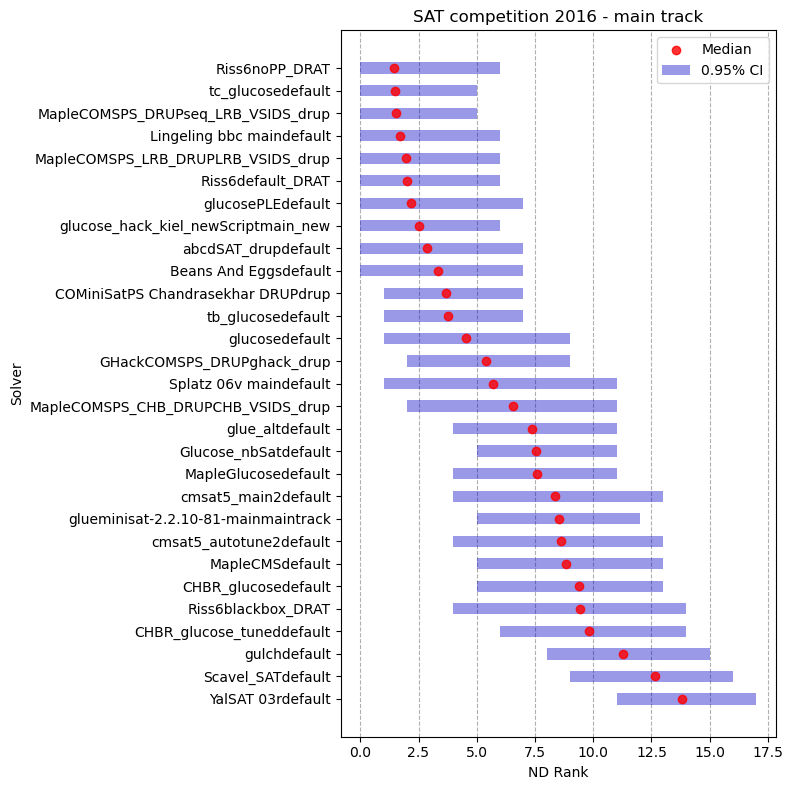

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
top = -1  # -1 shows all

cidf = ranking.sort_values("nd_rank_median", ascending=True)

means = []
yticks = []
handles = []

ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="--", zorder=-1)

n = len(cidf) if top <= 0 else min(len(cidf), top)
for i, (algorithm, bounds) in enumerate(cidf.iloc[:n].iterrows()):
    pos = n - i
    means.append([bounds["nd_rank_median"], pos])
    yticks.append(bounds["algorithm"])
    height = 0.5
    bar = patches.Rectangle(
        (bounds["nd_rank_ci_lb"], pos - (height / 2)),
        bounds["nd_rank_ci_ub"] - bounds["nd_rank_ci_lb"],
        height,
        facecolor=(0, 0, 0.78, 0.4),
        label="{:.2f}% CI".format(1 - comparison.alpha),
    )
    p = ax.add_patch(bar)

handles.append(ax.scatter(*zip(*means), color="red", label="Median", alpha=0.8))
handles.append(p)

ax.set_xlabel("ND Rank")
ax.set_ylabel("Solver")
ax.set_yticks(list(range(1, n + 1)))
ax.set_yticklabels(yticks[::-1])
ax.legend(handles=handles)
plt.title("SAT competition 2016 - main track")
plt.tight_layout()
plt.show()

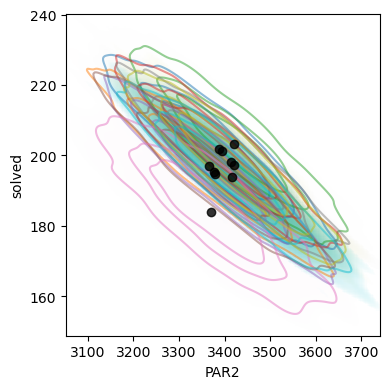

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
rr.utils.plots.plot_ci_density_estimations(comparison, algorithms=ranking.iloc[:10]["algorithm"].to_list(), show_names=False, ax=ax)
ranking.iloc[:10]["algorithm"].to_list()
plt.tight_layout()
plt.savefig("SAT2016_os.png", dpi=600)

In [34]:
comparison = rr.comparison.MODominationBootstrapComparison(competition,
                                 alpha=0.05,
                                 minimise={"PAR2": True, "solved": False},
                                 bootstrap_runs=1000,
                                 aggregation_method={"PAR2": np.mean, "solved": np.sum})

comparison.get_ranking()

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")


,group,ranked 1st,group wins,remaining
algorithm,,,,
Riss6noPP_DRAT,1,0.233,0.088,0.767
Lingeling bbc maindefault,1,0.213,0.071,0.554
tc_glucosedefault,1,0.142,0.245,0.412
MapleCOMSPS_LRB_DRUPLRB_VSIDS_drup,1,0.139,0.149,0.273
MapleCOMSPS_DRUPseq_LRB_VSIDS_drup,1,0.094,0.026,0.179
Riss6default_DRAT,1,0.053,0.157,0.126
abcdSAT_drupdefault,1,0.035,0.004,0.091
glucose_hack_kiel_newScriptmain_new,1,0.034,0.005,0.057
Beans And Eggsdefault,1,0.031,0.014,0.026


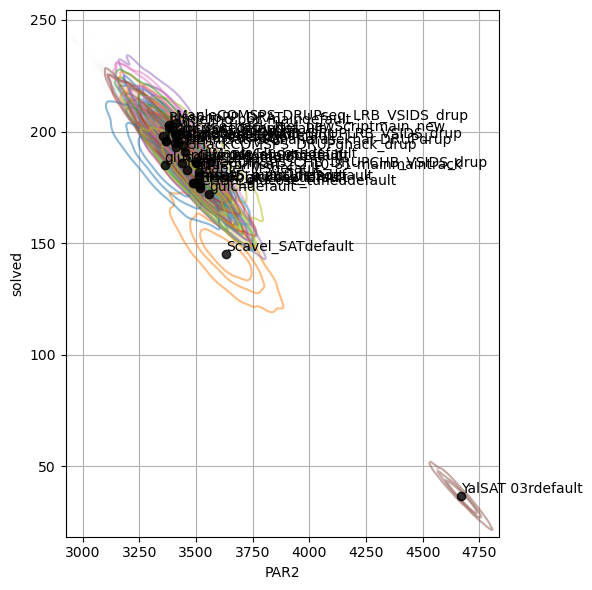

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
algs = [a for a in competition.algorithms if a not in ["Jeremy"]]
rr.utils.plots.plot_ci_density_estimations(comparison, algorithms=algs, show_names=True, ax=ax)
# ax.scatter([880], [3100], color="red")
# ax.text(880, 3100, "Ideal", color="red")
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
dist = comparison._get_distributions(always_minimise=False)
np.mean(dist, axis=0)

array([[14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14.5],
       [14

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
algs = [a for a in competition.algorithms if a not in ["Jeremy"]]
plot_ci_density_estimations(comparison, algorithms=algs, show_names=True, ax=ax)
# ax.scatter([880], [3100], color="red")
plt.grid()
plt.tight_layout()
plt.show()

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison/abstract_comparison.py:50: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")
/var/folders/b8/41_wfv893tnc356wksp2vkvw0000gn/T/ipykernel_40039/897792767.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ddf = ddf.merge(bsrank, left_index=True, right_index=True)


NameError: name 'fast_non_dominated_sorting' is not defined

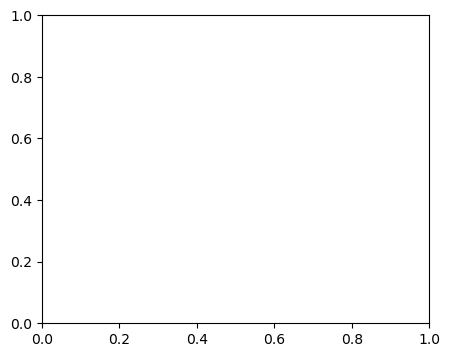

In [11]:
ddf = default_comparison.get_ranking().sort_values(("PAR2", "rank"))
ddf = ddf.merge(bsrank, left_index=True, right_index=True)

fig, ax = plt.subplots(1,1,figsize=(5,4))

points = ddf[[("PAR2", "score"), ("solved", "score")]].to_numpy()
points[:, 1] = -points[:, 1]
fronts , _, _, ndr = fast_non_dominated_sorting(points)
plt.scatter(ddf[("PAR2","score")], ddf[("solved","score")], c=ndr)
# for algo, row in ddf.iterrows():
#     # print(row[("PAR2","score")], row[("solved","score")])
#     plt.text(row[("PAR2","score")], row[("solved","score")], f"{row['group']:.0f}", clip_on=True)

for i, (algo, row) in enumerate(ddf.iterrows()):
    plt.text(row[("PAR2","score")], row[("solved","score")]+0.5, f"{ndr[i]+1}", clip_on=True, va="bottom", ha="center")
    
for algindex in np.argwhere(ndr == 0):
    iloc = algindex[0]
    series = ddf.iloc[iloc]
    # print(series.name)
    # print(series[("PAR2","score")], series[("solved","score")], series.name)
    #plt.text(series[("PAR2","score")], series[("solved","score")], series.name)
#plt.title("SAT competition 2016 - main track")

for i, front in enumerate(fronts[:1]):
    front_points = points[front, :]
    line = pareto_line(front_points, np.max(points, axis=0))
    line[:, 1] *= -1
    plt.plot(*line.T, color="grey", zorder=0, alpha=0.5)

plt.xlim(3300, 3700)
plt.xlabel("PAR2 (minimise)")
plt.ylim(170, 210)
plt.ylabel("Solved (maximise)")
plt.tight_layout()
plt.savefig("sat2016front.pdf")
plt.show()

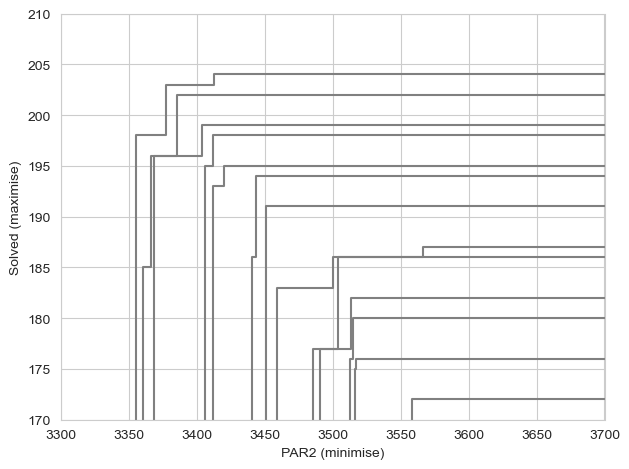

In [10]:
def pareto_line(points: np.ndarray, maxima: list[float | int]):
    points = points[points.argsort(axis=0)[:,0],:]
    line = [[points[0, 0], maxima[1]]]
    for i, (x, y) in enumerate(points):
        line.append([x, y])
        if i+1 < len(points):
            line.append([points[i+1,0], y])
        else:
            line.append([maxima[0], y])
    return np.array(line)

for i, front in enumerate(fronts):
    front_points = points[front, :]
    line = pareto_line(front_points, np.max(points, axis=0))
    line[:, 1] *= -1
    plt.plot(*line.T, color="grey")

plt.xlim(3300, 3700)
plt.xlabel("PAR2 (minimise)")
plt.ylim(170, 210)
plt.ylabel("Solved (maximise)")
plt.tight_layout()
plt.show()
plt.show()



# Compare MOrankings with SOrankings

In [18]:
for obj in comparison.benchmark.objectives:
    filtered_competition = comparison.benchmark.filter(objectives=obj)
    
    mo_comparison = MOBootstrapComparison(filtered_competition,
                                          minimise=comparison.minimise[obj],
                                          aggregation_method=comparison.aggregation_method[obj],
                                          alpha=0.05,
                                          bootstrap_runs=1000)
    
    so_comparison = BootstrapComparison(filtered_competition,
                                        minimise=comparison.minimise[obj],
                                        aggregation_method=comparison.aggregation_method[obj],
                                        alpha=0.05,
                                        bootstrap_runs=1000)
    
    mo_comparison.compute()
    so_comparison._cache = copy.copy(mo_comparison._cache)
    
    rdf = mo_comparison.get_ranking()
    rdf = rdf.merge(so_comparison.get_ranking(), left_index=True, right_index=True)
    verdict = np.count_nonzero(np.not_equal(rdf["group_x"].tolist(), rdf["group_y"].tolist())) == 0
    verdictlabel = "equal" if verdict else "not equal!!"
    print(f"{obj:10} rankings are {verdictlabel}")
    if not verdict:
        print(rdf["group_x"].tolist())
        print(rdf["group_y"].tolist())
        display(mo_comparison.get_comparison_table())
        display(so_comparison.get_comparison_table())

PAR2       rankings are equal
solved     rankings are equal


In [10]:
mo_comparison.get_comparison_table().stack().merge(so_comparison.get_comparison_table().stack(), left_index=True, right_index=True, suffixes=["_mo", "_so"])

wins_mo  wins_so
s1                    s2                                                   
Beans And Eggsdefault Beans And Eggsdefault                 1000.0   1000.0
                      CHBR_glucose_tuneddefault                1.0      1.0
                      CHBR_glucosedefault                      2.0      2.0
                      COMiniSatPS Chandrasekhar DRUPdrup     424.0    424.0
                      GHackCOMSPS_DRUPghack_drup             305.0    305.0
...                                                            ...      ...
tc_glucosedefault     glue_altdefault                         61.0     61.0
                      glueminisat-2.2.10-81-mainmaintrack      7.0      7.0
                      gulchdefault                             1.0      1.0
                      tb_glucosedefault                      328.0    328.0
                      tc_glucosedefault                     1000.0   1000.0

[841 rows x 2 columns]

In [11]:
distributions = comparison._get_cache()["distributions"]
distributions = copy.copy(distributions)
distributions[:, :, 1] *= -1
print(f"{distributions.shape=}")

allranks = []
for sample in range(distributions.shape[1]):
    _, _, _, ranks = fast_non_dominated_sorting(distributions[:, sample, :])
    allranks.append(ranks)
allranks = np.array(allranks).T
allranks.shape

distributions.shape=(29, 1000, 2)


(29, 1000)

In [12]:
np.argmax(np.count_nonzero(allranks == 1, axis=1))

6

## Plots


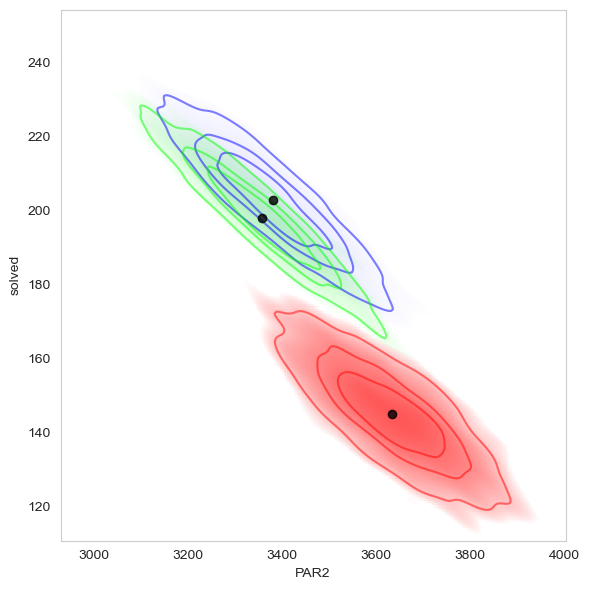

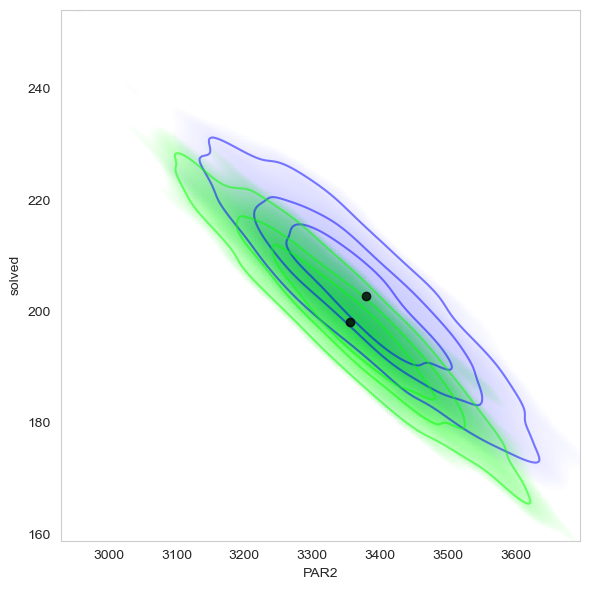

In [13]:
plot_ci_density_estimations(comparison, ["Riss6noPP_DRAT", "tc_glucosedefault", "Scavel_SATdefault"])
plot_ci_density_estimations(comparison, ["Riss6noPP_DRAT", "tc_glucosedefault"])

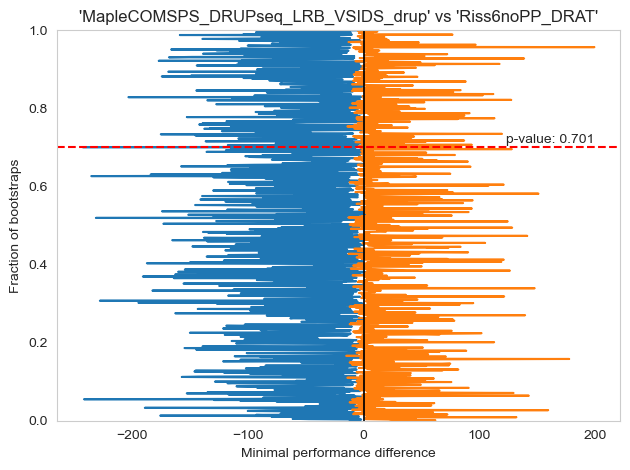

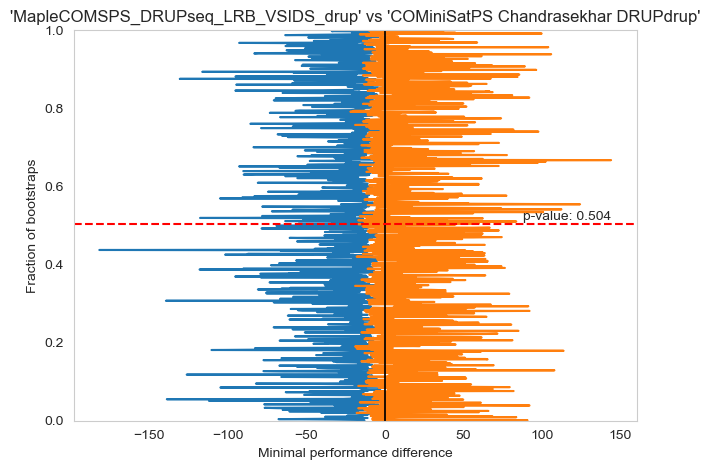

In [14]:
def plot_comparison_distribution(comparison, algorithms):
    cache = comparison._get_cache()
    s1 = cache["meta_data"]["algorithms"].index(algorithms[0])
    s2 = cache["meta_data"]["algorithms"].index(algorithms[1])

    distributions = cache["distributions"]
    p_value = comparison.statistical_test(*algorithms)
    direction = -1 if comparison.minimise else 1
    diff = direction * (distributions[s1,:] - distributions[s2,:])
    diff = np.sort(diff)
    plt.grid()
    plt.plot(diff, np.linspace(0, 1, len(diff)))
    plt.axvline(0, c="black", linewidth=1.25, linestyle="-")
    plt.axhline(p_value, c="red", linestyle="--")
    plt.text(diff.max() , p_value+0.01, f"p-value: {p_value:.3f}", ha="right")
    plt.title(f"'{algorithms[0]}' vs '{algorithms[1]}'")
    plt.xlabel("Minimal performance difference")
    plt.ylabel("Fraction of bootstraps")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


plot_comparison_distribution(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "Riss6noPP_DRAT"])
plot_comparison_distribution(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "COMiniSatPS Chandrasekhar DRUPdrup"])

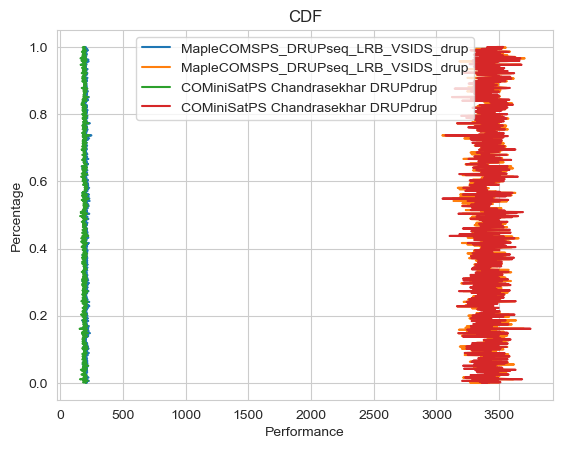

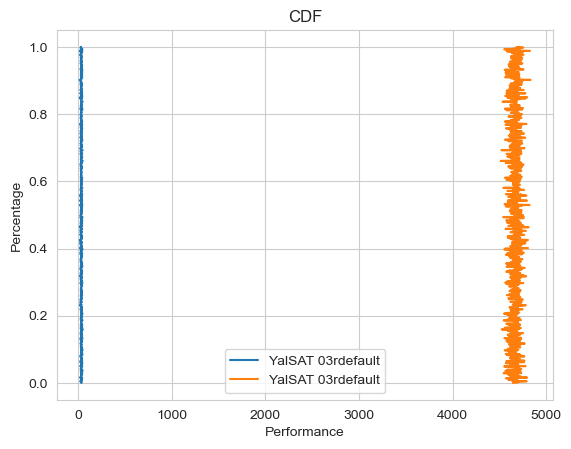

In [15]:
def plot_distribution_cdf(comparison, algorithms):
    cache = comparison._get_cache()
    distributions = cache["distributions"]

    if not isinstance(algorithms, list):
        algorithms = [algorithms]

    for algorithm in algorithms:
        s1 = cache["meta_data"]["algorithms"].index(algorithm)

        #direction = -1 if comparison.minimise else 1
        diff = distributions[s1,:]
        diff = np.sort(diff)
        plt.plot(diff, np.linspace(0, 1, len(diff)), label=algorithm)

    # plt.axhline(0, c="black", linewidth=1.25, linestyle="-")
    # plt.axvline(p_value, c="red", linestyle="--")
    # plt.text(p_value+0.01, diff.max(), f"p-value = {p_value:.3%}")
    plt.title("CDF")
    plt.xlabel("Performance")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

plot_distribution_cdf(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "COMiniSatPS Chandrasekhar DRUPdrup"])
plot_distribution_cdf(comparison, ["YalSAT 03rdefault"])

In [16]:
fronts, dominates, domination_count, ranks = fast_non_dominated_sorting(points)

In [17]:
comparison = BootstrapComparison(competition,
                                 alpha=0.05,
                                 minimise={"PAR2": True, "solved": False},
                                 bootstrap_runs=10000,
                                 aggregation_method={"PAR2": np.mean, "solved": np.sum})

comparison.compute()

In [18]:
dist = comparison._get_cache()["distributions"]
dist.shape
allranks = []
for sample in range(dist.shape[1]):
    _, dl, _, ranks = fast_non_dominated_sorting(dist[:, sample, :])
    allranks.append(ranks)
allranks = np.array(allranks)
avranks = np.mean(allranks, axis=0)

In [19]:
np.argsort(np.argsort(avranks))

array([21,  1, 15,  3,  4,  0, 19, 26,  6,  5, 20, 14, 11,  9, 27, 13, 24,
       16, 28, 25,  2, 23, 22, 17, 12,  7, 18,  8, 10])

In [20]:
allranks.shape

(10000, 29)

In [21]:
a = np.random.rand(8,1000,2)
np.mean(a, axis=1)

array([[0.5008703 , 0.50297121],
       [0.50565999, 0.50128407],
       [0.4864395 , 0.48936062],
       [0.49662023, 0.50155548],
       [0.50272003, 0.50129317],
       [0.5052422 , 0.50119211],
       [0.49002375, 0.49134641],
       [0.49585745, 0.51667543]])